<img style="float: right;" src="../htwlogo.jpg">

# RANSAC line grouping

**Author**: _Erik Rodner_<br>
**Lecture**: Computer Vision and Machine Learning I

In the following notebook, we will look at line grouping using random sample consensus (RANSAC)

In [70]:
# import our usual friends
from skimage.io import imread, imsave
import matplotlib.pylab as plt
import numpy as np
import skimage.data as examples
from skimage.color import rgb2gray
from skimage import feature

# some code that allows us to find the simulation code
import sys
import os
sys.path.append(os.path.join("..", "utils"))

## Getting edge pixels

Let's simply detect edge pixel candidates by using the Canny detector first

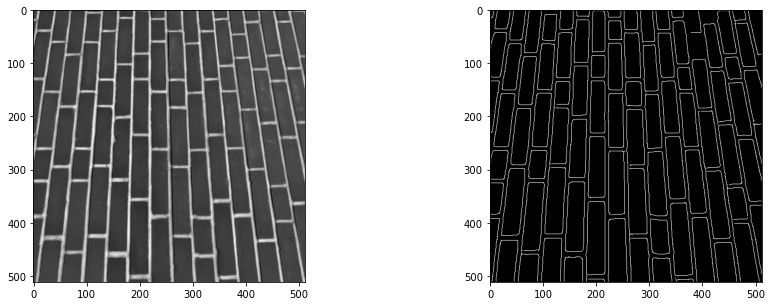

In [71]:
img = examples.brick()
edges = feature.canny(img, sigma=3)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(img, cmap=plt.cm.gray)
plt.subplot(1,2,2)
plt.imshow(edges, cmap=plt.cm.gray)


### Applying RANSAC

Let us first get all edge candidates as points in $(x,y)$

In [72]:
edge_points_y, edge_points_x = np.where(edges)
num_points = len(edge_points_x)

Start with RANSAC using a specific number of subsets that we draw from the whole point set. We simply draw pairs of points and estimate the parameters of a straight line.

The supporters are calculated by thresholding the distance to the line with ```eps```, i.e. all edge pixels that are less than ```eps``` pixels away from the line are calculated as supportive.

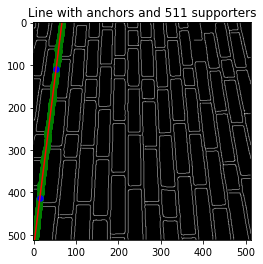

In [73]:
num_subsets = 1000
eps = 3
lines = []

for i in range(num_subsets):    
    # draw a pair of points
    anchors = np.random.randint(num_points, size=2)
    y1, y2 = edge_points_y[anchors]
    x1, x2 = edge_points_x[anchors]

    # calculate the equation of the line
    # in the form of a*x + b*y + c = 0
    a = (y2-y1)
    b = (x1-x2)
    c = -(y2-y1)*x1 - (x1-x2)*y1
    
    # now we use the Hessesche Normalform to compute distances to all other edge pixels
    norm = np.sqrt(a**2 + b**2)
    if np.abs(norm)<1:
        # equal points sampled
        continue
    
    distances = np.abs(a*edge_points_x + b*edge_points_y + c)/norm
    
    # thresholding and counting gives us the number of supporters
    supporters_indices = distances<eps
    num_supporters = np.sum(supporters_indices)
    
    lines.append((-num_supporters, [x1, y1, x2, y2]))
    
    # showing examples that look promising
    if num_supporters>510:
        plt.figure()
        plt.imshow(edges, cmap=plt.cm.gray)
        plt.gca().axline((x1, y1), (x2, y2), color="red")
        # show all supporters of the line
        plt.scatter(edge_points_x[supporters_indices], edge_points_y[supporters_indices], color="green")
        plt.scatter([x1, x2], [y1, y2], s=30, color="blue")
        plt.title(f"Line with anchors and {num_supporters} supporters")
        plt.show()

### Visualizing the result

Finally, we show the top ```num_lines``` lines with most supporters. Can we recognize what might be missing?

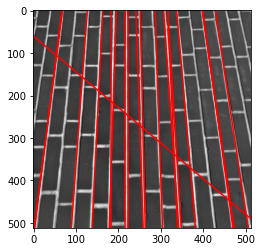

In [74]:
lines = sorted(lines)
num_lines = 20

plt.imshow(img, cmap=plt.cm.gray)
for _, parameters in lines[:num_lines]:
    
    y = np.arange(img.shape[0])
    x1, y1, x2, y2 = parameters
    
    plt.gca().axline((x1, y1), (x2, y2), color="red")
    
plt.show()